# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_date_dir_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [62]:
# デバッグモード
debug = True

res = AppRes()
excel = "ticks_20260123.xlsx"
# code = "285A"
code = "7011"
# code = "7203"
# code = "8306"
# code = "9984"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
THRESHOLD_PM_MIN = dict_setting["THRESHOLD_PM_MIN"]
THRESHOLD_DDR_MIN = dict_setting["THRESHOLD_DDR_MIN"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/01/23
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 50
PERIOD_MA_2 : 800
PERIOD_SLOPE : 7
THRESHOLD_SLOPE : 0.1
PERIOD_RR : 30
TURBULENCE : 20.0
LOSSCUT_1 : -10
THRESHOLD_PM_MIN : 4.0
THRESHOLD_DDR_MIN : 0.3
N_MINUS_MAX : 240


In [63]:
# 取引明細
df_transaction = app.getTransaction()
df_transaction["累積損益"] = df_transaction["損益"].fillna(0).cumsum()
print("取引明細")
print(df_transaction)
print(df_transaction["注文日時"].dtype)
print(df_transaction["累積損益"].dtype)

list_html = conv_transaction_df2html(df_transaction)

if debug:
    output_dir = os.path.join("tmp", date_str)
else:
    output_dir = os.path.join("output", date_str)

os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_transaction.html")
print(output)
with open(output, mode="w") as f:
    f.write("\n".join(list_html))

list_trans = df_transaction["注文日時"]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
    注文番号                          注文日時 銘柄コード  売買  約定単価  約定数量      損益 備考  \
0      1 2026-01-23 09:26:52.180922031  9984  買建  4142   100     NaN      
1      2 2026-01-23 09:28:02.391530991  9984  売埋  4132   100 -1000.0      
2      3 2026-01-23 09:28:16.412899017  9984  売建  4131   100     NaN      
3      4 2026-01-23 09:28:28.427937031  9984  買埋  4128   100   300.0      
4      5 2026-01-23 09:30:40.969837904  9984  買建  4144   100     NaN      
5      6 2026-01-23 09:32:24.202950001  9984  売埋  4147   100   300.0      
6      7 2026-01-23 10:03:15.105624914  9984  売建  4148   100     NaN      
7      8 2026-01-23 10:04:28.371022940  9984  買埋  4155   100  -700.0      
8      9 2026-01-23 10:11:52.818772078  9984  買建  4161   100     NaN      
9     10 2026-01-23 10:12:07.909293890  9984  売埋  4164   100   300.0      
10    11 2026-01-23 10:35:29.804881096  9984  買建  4173   100     NaN      
11    12 2026-01-23 10:35:57.884413958  9984  売埋  4165   100  -800.0      
12    13 2026-01-23 

In [64]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [65]:
"""
累積損益のトレンドを作成するための準備
"""

# 元データ
ts = df_transaction["注文日時"]
pl = df_transaction["累積損益"]

# 日付（年月日）だけ取り出す
date = ts.iloc[0].normalize()

# 追加する先頭と末尾の行
start_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=9)],
        "累積損益": [0.0],
    }
)

end_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=15, minutes=30)],
        "累積損益": [pl.iloc[-1]],
    }
)

# トレンド用 DataFrame を作成
trend_df = pd.concat(
    [start_row, df_transaction[["注文日時", "累積損益"]], end_row], ignore_index=True
)

# 注文日時を index にした Series を作成
trend_series = trend_df.set_index("注文日時")["累積損益"]
trend_series

注文日時
2026-01-23 09:00:00.000000000       0.0
2026-01-23 09:26:52.180922031       0.0
2026-01-23 09:28:02.391530991   -1000.0
2026-01-23 09:28:16.412899017   -1000.0
2026-01-23 09:28:28.427937031    -700.0
2026-01-23 09:30:40.969837904    -700.0
2026-01-23 09:32:24.202950001    -400.0
2026-01-23 10:03:15.105624914    -400.0
2026-01-23 10:04:28.371022940   -1100.0
2026-01-23 10:11:52.818772078   -1100.0
2026-01-23 10:12:07.909293890    -800.0
2026-01-23 10:35:29.804881096    -800.0
2026-01-23 10:35:57.884413958   -1600.0
2026-01-23 10:50:35.961147070   -1600.0
2026-01-23 10:52:39.389586926   -1900.0
2026-01-23 12:30:42.368479013   -1900.0
2026-01-23 12:32:02.588993073    -300.0
2026-01-23 12:57:32.431910992    -300.0
2026-01-23 12:57:46.459355116    -200.0
2026-01-23 13:00:52.236913919    -200.0
2026-01-23 13:02:21.555974960     400.0
2026-01-23 13:06:27.528182983     400.0
2026-01-23 13:06:53.703463078    1500.0
2026-01-23 13:42:07.530000924    1500.0
2026-01-23 13:42:16.548430920    17

output/2026/01/23/9984_trend_profit.png


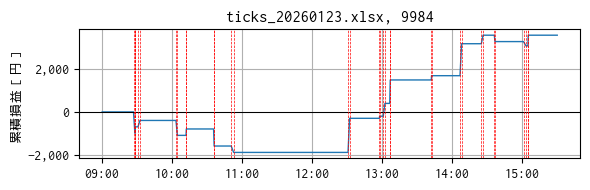

In [66]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [67]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts  price      ma1         ma2  mr  disparity  \
2026-01-23 09:00:02  1.769126e+09   4317  4317.00  4317.00000   0   0.000000   
2026-01-23 09:00:03  1.769126e+09   4317  4317.00  4317.00000   0   0.000000   
2026-01-23 09:00:04  1.769126e+09   4302  4312.00  4312.00000  15   0.000000   
2026-01-23 09:00:05  1.769126e+09   4302  4309.50  4309.50000  15   0.000000   
2026-01-23 09:00:06  1.769126e+09   4299  4307.40  4307.40000  18   0.000000   
...                           ...    ...      ...         ...  ..        ...   
2026-01-23 15:24:45  1.769149e+09   4266  4266.00  4253.83000   8   0.002861   
2026-01-23 15:24:46  1.769149e+09   4265  4266.00  4253.85500   8   0.002855   
2026-01-23 15:24:47  1.769149e+09   4265  4266.00  4253.88125   8   0.002849   
2026-01-23 15:24:48  1.769149e+09   4262  4265.92  4253.90375   8   0.002825   
2026-01-23 15:24:49  1.769149e+09   4262  4265.84  4253.92625   8   0.002801   

                       slope1  

In [68]:
df_tech["slope1"].describe()

count    19426.000000
mean         0.092164
std          0.111251
min          0.000000
25%          0.027473
50%          0.060220
75%          0.117363
max          3.000000
Name: slope1, dtype: float64

output/2026/01/23/9984_trend_technical.png


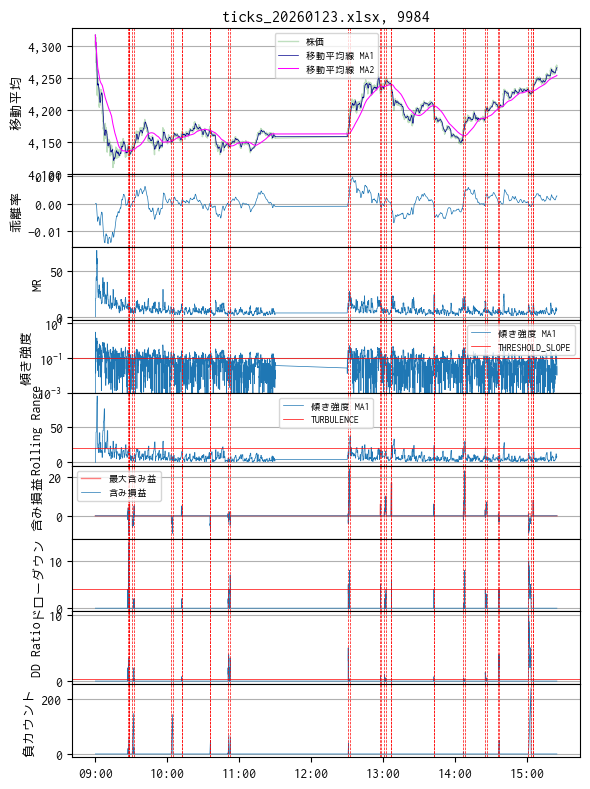

In [69]:
fig = plt.figure(figsize=(6, 8))
n = 9
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["disparity"], linewidth=0.5, label="MA乖離率")
ax[1].set_ylabel("乖離率")

ax[2].plot(df_tech["mr"], linewidth=0.5, label="移動範囲")
ax[2].set_ylabel("MR")

ax[3].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[3].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
ax[3].set_yscale("log")
ax[3].set_ylabel("傾き強度")
ax[3].legend(fontsize=7)
_, y_high = ax[3].get_ylim()
ax[3].set_ylim(0.001, y_high)

ax[4].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[4].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[4].set_ylabel("Rolling Range")
ax[4].legend(fontsize=7)

ax[5].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[5].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[5].set_ylabel("含み損益")
ax[5].legend(fontsize=7)

ax[6].plot(df_tech["drawdown"], linewidth=0.5)
ax[6].axhline(y=THRESHOLD_PM_MIN, color="red", linewidth=0.5, label="THRESHOLD_PM_MIN")
ax[6].set_ylabel("ドローダウン")

ax[7].plot(df_tech["dd_ratio"], linewidth=0.5)
ax[7].axhline(
    y=THRESHOLD_DDR_MIN, color="red", linewidth=0.5, label="THRESHOLD_DDR_MIN"
)
ax[7].set_ylabel("DD Ratio")

ax[8].plot(df_tech["n_minus"], linewidth=0.5)
ax[8].set_ylabel("負カウント")

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/23/9984_hist_slope.png


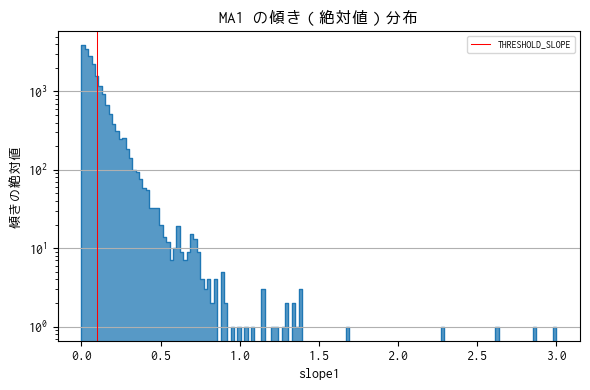

In [70]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/23/9984_hist_rr.png


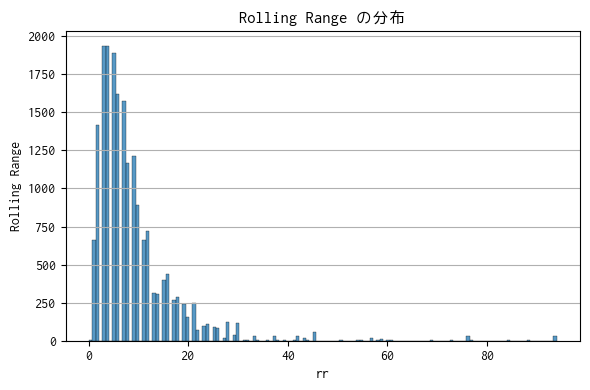

In [71]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_rr.png")
print(output)
plt.savefig(output)
plt.show()

In [72]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1  ロス2  利確1   建玉
2026-01-23 09:00:02    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-23 09:00:03    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-23 09:00:04    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-23 09:00:05    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-23 09:00:06    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...  ...  ...
2026-01-23 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-23 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-23 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-23 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-23 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0

[19426 rows x 8 columns]


output/2026/01/23/9984_trend_obs.png


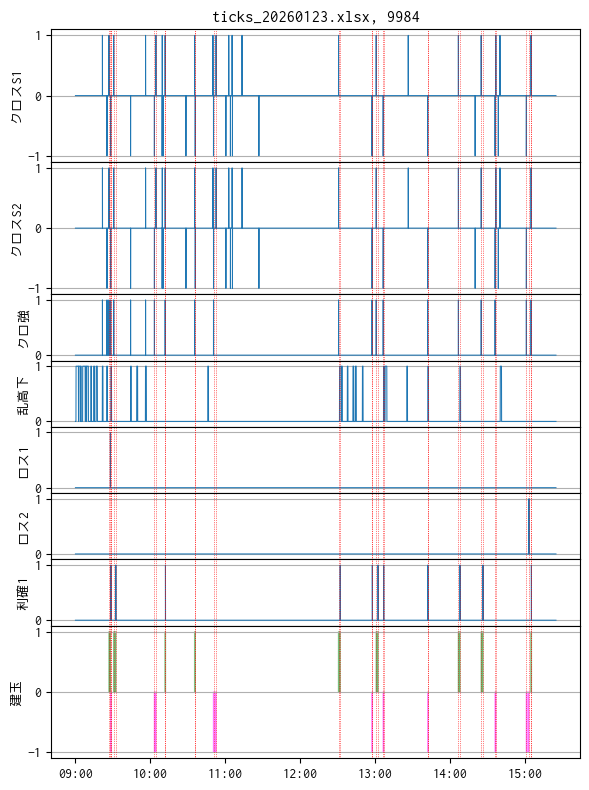

In [73]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(
            x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True
        )
        ax_i.fill_between(
            x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True
        )
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_obs.png")
print(output)
plt.tight_layout()
plt.savefig(output)
plt.show()